In [1]:
import pandas as pd
import numpy as np
#import statsmodels.api as sm
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime, timedelta
import seaborn as sb
import os
os.chdir('/home/saul/python')


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [2]:
bike_rental = pd.read_csv('bike_rental_dataset.csv')

### Data Preprocessing

##### Convert date variable to data format

In [3]:
bike_rental['date'] = bike_rental['datetime'].str.split(" ").str[0]
bike_rental['hour_mins'] = bike_rental['datetime'].str.split(" ").str[1]

bike_rental['date'] = bike_rental['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [4]:
bike_rental['date'].head(-5)

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
17345   2012-12-30
17346   2012-12-30
17347   2012-12-30
17348   2012-12-30
17349   2012-12-30
Name: date, Length: 17350, dtype: datetime64[ns]

###### Exclude days from 24/12/2012 onwards

In [5]:
bike_rental = bike_rental[bike_rental['date'] < '2012-12-24']  # remove observation to be predicted

In [6]:
bike_rental['date'].value_counts()

2011-01-01    24
2012-06-26    24
2012-04-23    24
2012-04-24    24
2012-04-25    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: date, Length: 723, dtype: int64

###### Missing values

In [7]:
print(f'Number of rows with missing values: {bike_rental.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.000581767409389726


In [8]:
get_missing_data = bike_rental[bike_rental.isnull().any(axis=1)]

In [9]:
get_missing_data # show missing values in the dataset

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour_mins
14,1/01/2011 14:00,1,0,0,2,0.46,0.4545,NaN,0.2836,106.0,2011-01-01,14:00
56,3/01/2011 11:00,1,0,1,1,0.20,0.1818,NaN,0.3284,51.0,2011-01-03,11:00
93,5/01/2011 1:00,1,0,1,1,0.16,0.1970,NaN,0.0896,6.0,2011-01-05,1:00
166,8/01/2011 5:00,1,0,0,2,0.16,0.1667,NaN,0.1642,5.0,2011-01-08,5:00
762,4/02/2011 5:00,1,0,1,2,0.14,0.1515,NaN,0.1343,7.0,2011-02-04,5:00
3537,1/06/2011 7:00,2,0,1,2,0.70,0.6667,NaN,0.1642,284.0,2011-06-01,7:00
8796,7/01/2012 8:00,1,0,0,1,0.24,0.2576,NaN,0.1045,64.0,2012-01-07,8:00
13102,5/07/2012 3:00,3,0,1,1,0.72,0.6667,NaN,0.1940,7.0,2012-07-05,3:00
15947,2/11/2012 4:00,4,0,1,1,0.30,0.3182,NaN,0.1045,7.0,2012-11-02,4:00
16505,25/11/2012 11:00,4,0,0,2,0.26,0.2576,NaN,0.2239,204.0,2012-11-25,11:00


###### Replace NaN  values with zero in the dataset

In [10]:
bike_rental = bike_rental.replace(np.nan, 0)

In [11]:
get_missing_data = bike_rental[bike_rental.isnull().any(axis=1)]

In [12]:
get_missing_data # show missing values in the dataset

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour_mins


In [13]:
print(f'Number of rows with missing values: {bike_rental.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [14]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17189 entries, 0 to 17188
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17189 non-null  object        
 1   season      17189 non-null  int64         
 2   holiday     17189 non-null  int64         
 3   workingday  17189 non-null  int64         
 4   weather     17189 non-null  int64         
 5   temp        17189 non-null  float64       
 6   atemp       17189 non-null  float64       
 7   humidity    17189 non-null  float64       
 8   windspeed   17189 non-null  float64       
 9   count       17189 non-null  float64       
 10  date        17189 non-null  datetime64[ns]
 11  hour_mins   17189 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(4), object(2)
memory usage: 1.7+ MB


###### rename season values meaningful name

In [18]:

bike_rental['season'] = bike_rental['season'].replace('1', 'Spring')

bike_rental['season'] = bike_rental['season'].replace('2', 'Summer')
bike_rental['season'] = bike_rental['season'].replace('3', 'Fall')
bike_rental['season'] = bike_rental['season'].replace('4', 'Winter')

###### Convert numerical values to categorical

In [19]:
bike_rental = bike_rental.astype({'season':'string', 'holiday':'category', 'workingday':'category', 
                                  'weather':'category'})

In [20]:
bike_rental['season'].value_counts()

Fall      4496
Summer    4409
Winter    4232
Spring    4052
Name: season, dtype: Int64

In [21]:
bike_rental.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour_mins
0,1/01/2011 0:00,Spring,0,0,1,0.24,0.2879,0.81,0.0,16.0,2011-01-01,0:00
1,1/01/2011 1:00,Spring,0,0,1,0.22,0.2727,0.80,0.0,40.0,2011-01-01,1:00
2,1/01/2011 2:00,Spring,0,0,1,0.22,0.2727,0.80,0.0,32.0,2011-01-01,2:00
3,1/01/2011 3:00,Spring,0,0,1,0.24,0.2879,0.75,0.0,13.0,2011-01-01,3:00
4,1/01/2011 4:00,Spring,0,0,1,0.24,0.2879,0.75,0.0,1.0,2011-01-01,4:00


In [22]:
bike_rental.describe()

,temp,atemp,humidity,windspeed,count
count,17189.000000,17189.000000,17189.000000,17189.000000,17189.000000
mean,0.499721,0.478339,0.626329,0.189842,190.774914
std,0.191798,0.170996,0.193792,0.122048,181.805639
min,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.500000,0.484800,0.630000,0.194000,144.000000
75%,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,1.000000,1.000000,0.850700,977.000000


In [23]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17189 entries, 0 to 17188
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17189 non-null  object        
 1   season      17189 non-null  string        
 2   holiday     17189 non-null  category      
 3   workingday  17189 non-null  category      
 4   weather     17189 non-null  category      
 5   temp        17189 non-null  float64       
 6   atemp       17189 non-null  float64       
 7   humidity    17189 non-null  float64       
 8   windspeed   17189 non-null  float64       
 9   count       17189 non-null  float64       
 10  date        17189 non-null  datetime64[ns]
 11  hour_mins   17189 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(5), object(2), string(1)
memory usage: 1.4+ MB


In [24]:
bike_rental['date'].value_counts()

2011-01-01    24
2012-06-26    24
2012-04-23    24
2012-04-24    24
2012-04-25    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: date, Length: 723, dtype: int64

###### Get daily bike total counts

In [25]:
daily_counts = pd.pivot_table(bike_rental, values = 'count', index=['date'], aggfunc= 'sum').reset_index()

In [26]:
daily_counts = pd.DataFrame(daily_counts.to_records())
daily_counts = daily_counts.rename(columns={'count':'daily_total_rent'})

In [27]:
daily_counts.columns

Index(['index', 'date', 'daily_total_rent'], dtype='object')

###### Get start of each week

In [28]:
bike_rental['day_of_week'] = bike_rental['date'].dt.dayofweek

bike_rental["first_day_of_the_week"] = bike_rental.date - bike_rental.day_of_week * timedelta(days=1) # Get First day of Week

In [29]:
bike_rental.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour_mins,day_of_week,first_day_of_the_week
0,1/01/2011 0:00,Spring,0,0,1,0.24,0.2879,0.81,0.0,16.0,2011-01-01,0:00,5,2010-12-27
1,1/01/2011 1:00,Spring,0,0,1,0.22,0.2727,0.80,0.0,40.0,2011-01-01,1:00,5,2010-12-27
2,1/01/2011 2:00,Spring,0,0,1,0.22,0.2727,0.80,0.0,32.0,2011-01-01,2:00,5,2010-12-27
3,1/01/2011 3:00,Spring,0,0,1,0.24,0.2879,0.75,0.0,13.0,2011-01-01,3:00,5,2010-12-27
4,1/01/2011 4:00,Spring,0,0,1,0.24,0.2879,0.75,0.0,1.0,2011-01-01,4:00,5,2010-12-27


###### Get weekly bike rents

In [30]:
weekly_counts = pd.pivot_table(bike_rental, values = 'count', index=['first_day_of_the_week'], aggfunc= 'sum').reset_index()

weekly_counts = pd.DataFrame(weekly_counts.to_records())
weekly_counts = weekly_counts.rename(columns={'count':'weekly_total_rent'})

In [31]:
weekly_counts.to_csv('weekly_bike_counts.csv', index=False)

In [32]:
weekly_counts.describe() # Weekly bike rent quintiles

,index,weekly_total_rent
count,104.000000,104.000000
mean,51.500000,31531.057692
std,30.166206,12449.390349
min,0.000000,1786.000000
25%,25.750000,23658.500000
50%,51.500000,30982.000000
75%,77.250000,42433.250000
max,103.000000,55022.000000


In [33]:
bike_rental.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'date', 'hour_mins',
       'day_of_week', 'first_day_of_the_week'],
      dtype='object')

##### Plot daily bike rental in time series

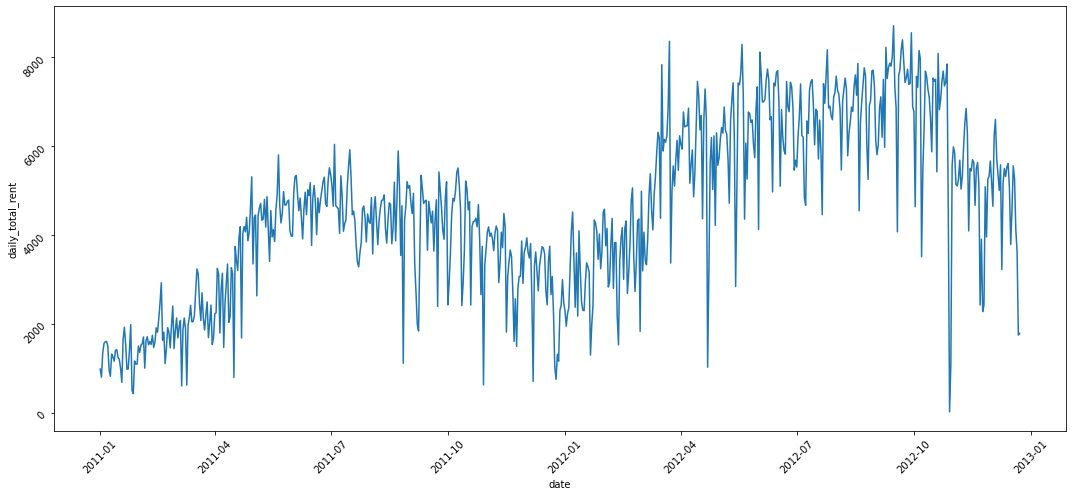

In [34]:
plt.rcParams["figure.figsize"] = [15.00, 7]
plt.rcParams["figure.autolayout"] = True

ax = sb.lineplot(x="date", y="daily_total_rent", data=daily_counts)

ax.tick_params(rotation=45)

plt.show()

##### Plot weekly bike rental in time series

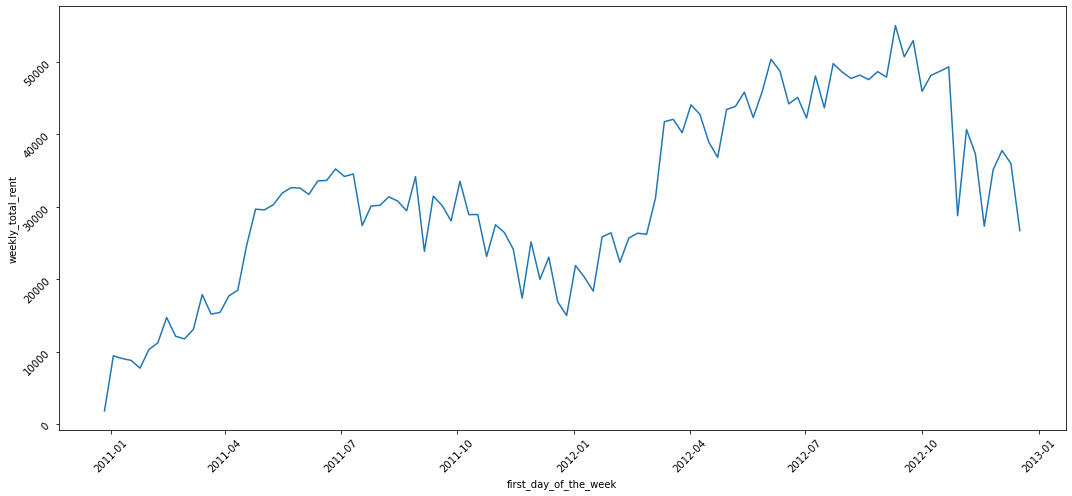

In [35]:
plt.rcParams["figure.figsize"] = [15.00, 7]
plt.rcParams["figure.autolayout"] = True

ax = sb.lineplot(x="first_day_of_the_week", y="weekly_total_rent", data=weekly_counts)

ax.tick_params(rotation=45)

plt.show()

###### By looking at the time series graph, there is seasonality during the xmas period (the number of bikes rented during and toward the period is declined) 

#### Time Series Analysis of weekly rentals

###### Prediction with sklearn RandomForestRegressor

###### Add daily total bike counts to bike dataset

In [36]:
#add daily total counts to the original dataset
bike_rental = bike_rental.merge(daily_counts, on = 'date', how='left') #add daily counts

In [37]:
bike_rental.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'date', 'hour_mins',
       'day_of_week', 'first_day_of_the_week', 'index', 'daily_total_rent'],
      dtype='object')

In [38]:
len(bike_rental)

17189

###### Add weekly total bike counts to bike dataset

In [39]:
#add weekly counts to the original dataset
bike_rental_weekly_count = bike_rental.merge(weekly_counts, on = 'first_day_of_the_week', how='left') #add weekly counts

In [40]:
len(bike_rental_weekly_count )

17189

In [41]:
len(bike_rental)

17189

In [42]:
bike_rental_weekly_count.to_excel('bike_rental_weekly_count.xlsx')

###### Daily Prediction